# 0. About This Colab Notebook

1. This Colab is designed for the course "**Computer Programming in Python**" instructed by Tse-Yu Lin.

2. Note that each time you enter this Colab from the link provided by the instructor, TAs or other people.
Please create a copy to your own Google Drive by clicking **File > Save a copy in Drive**. After clicking, a new tab page will be opened.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.container import BarContainer
from matplotlib.text import Text
from typing import Literal

sns.set_palette(palette="pastel")
sns.set()

# a) Preparation: Download Dataset

We import the following package ``gdown`` to download files from Google Drive.

In [ ]:
filename = "disney_plus_titles.csv"
if "get_ipython" in dir() and "google.colab" in str(get_ipython()):
    import gdown

    url = "https://drive.google.com/u/1/uc?id=118sEZB_-OfyXH130f-EED4KI26AXH8FO&export=download"
    # mirror_url = "https://drive.google.com/u/1/uc?id=1xlzqH8z2ChAO4xPpm3GDfslyni53Bn5j&export=download"
    gdown.download(url, filename)

In [ ]:
raw_df = pd.read_csv(filename)

In [ ]:
m, n = raw_df.shape
print(f"Size of dataset: {m}")
print(f"Number of Features: {n}")

Size of dataset: 1450
Number of Features: 12


In [ ]:
raw_df.sample(n=5, random_state=42)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
538,s539,Movie,Homeward Bound II: Lost in San Francisco,David Ellis,"Robert Hays, Kim Greist, Veronica Lauren, Kevi...",United States,"May 1, 2020",1996,G,90 min,"Action-Adventure, Animals & Nature, Family",Three lost pets must navigate through San Fran...
754,s755,Movie,Boat Builders,Ben Sharpsteen,NaN,United States,"November 12, 2019",1938,TV-G,8 min,"Animation, Comedy, Family",Mickey and friends build a boat but it falls a...
49,s50,Movie,The Search for Santa Paws,Robert Vince,"Resse Alexander, Diedrich Bader, Sahar Biniaz,...",Canada,"November 5, 2021",2010,G,101 min,"Drama, Family, Fantasy",Discover how the legendary friendship of Santa...
1380,s1381,Movie,Toy Story Toons: Hawaiian Vacation,Gary Rydstrom,"Tom Hanks, Tim Allen, Joan Cusack, Kristen Sch...",United States,"November 12, 2019",2011,G,6 min,"Animation, Comedy, Family",Ken and Barbie get the vacation of their dreams.
141,s142,TV Show,Cesar Millan: Better Human Better Dog,NaN,Dustin Rubin,NaN,"August 4, 2021",2021,TV-14,1 Season,"Animals & Nature, Docuseries, Family",Renowned Dog Behaviorist Cesar Millan transfor...


Please refer the following link for more detail about headers:
* Disney+ Movies and TV Shows: https://www.kaggle.com/datasets/shivamb/disney-movies-and-tv-shows

# b) Data Analysis on Your Own

In [ ]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1450 entries, 0 to 1449
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       1450 non-null   object
 1   type          1450 non-null   object
 2   title         1450 non-null   object
 3   director      977 non-null    object
 4   cast          1260 non-null   object
 5   country       1231 non-null   object
 6   date_added    1447 non-null   object
 7   release_year  1450 non-null   int64 
 8   rating        1447 non-null   object
 9   duration      1450 non-null   object
 10  listed_in     1450 non-null   object
 11  description   1450 non-null   object
dtypes: int64(1), object(11)
memory usage: 136.1+ KB


## Define Utility Functions

In [ ]:
def rotate_label(
    label: Text,
    rotation: float | Literal["vertical", "horizontal"],
    align: Literal["left", "center", "right"] = "right",
) -> None:
    """Rotates a given `Text` instance by `rotation` degrees.

    Args:
        label: The `Text` instance to rotate.
        rotation: The rotation in degrees.
        align: The horizontal alignment of the resulting object. Defaults to "right".
    """
    label.set_rotation(rotation)
    label.set_ha(align)

---

## Clean the Data

In [ ]:
cleaned_df = (
    raw_df.drop(labels=["director", "description"], axis="columns")
    .dropna(subset=["rating", "date_added"], how="any", axis="index")
    .assign(
        date_added=pd.to_datetime(raw_df["date_added"], format="%B %d, %Y"),
        duration=raw_df["duration"].str.extract("([0-9]+)").astype(int),
        cast=raw_df["cast"].str.split(", "),
        country=raw_df["country"].str.split(", "),
        listed_in=raw_df["listed_in"].str.split(", "),
    )
    .convert_dtypes()
    .set_index(keys=["type", "rating", "release_year", "date_added", "show_id"])
    .sort_index()
)

cleaned_df.info()
cleaned_df

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1444 entries, ('Movie', 'G', 1937, Timestamp('2019-11-12 00:00:00'), 's1200') to ('TV Show', 'TV-Y7-FV', 2021, Timestamp('2021-04-02 00:00:00'), 's266')
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      1444 non-null   string
 1   cast       1255 non-null   object
 2   country    1228 non-null   object
 3   duration   1444 non-null   Int32 
 4   listed_in  1444 non-null   object
dtypes: Int32(1), object(3), string(1)
memory usage: 114.6+ KB


title  \
type    rating   release_year date_added show_id                                                   
Movie   G        1937         2019-11-12 s1200                   Snow White and The Seven Dwarfs   
                 1940         2019-11-12 s1130                                         Pinocchio   
                                         s884                                           Fantasia   
                 1941         2019-11-12 s1326                              The Reluctant Dragon   
                 1942         2019-11-12 s739                                              Bambi   
...                                                                                          ...   
TV Show TV-Y7-FV 1985         2021-06-18 s196                          Star Wars Vintage: Droids   
                 2015         2019-11-12 s1005         LEGO Star Wars: Resistance Rises (Shorts)   
                 2019         2019-11-12 s1214                                  Star Wars: Blips   
                 2020         2021-02-12 s301     Marvel Battleworld: Mystery of the Thanostones   
                 2021         2021-04-02 s266      Star Wars Vintage: Clone Wars 2D Micro-Series   

                                                                                               cast  \
type    rating   release_year date_added show_id                                                      
Movie   G        1937         2019-11-12 s1200    [Adriana Caselotti, Harry Stockwell, Lucille L...   
                 1940         2019-11-12 s1130    [Dickie Jones, Christian Rub, Cliff Edwards, E...   
                                         s884        [Deems Taylor, Walt Disney, Leopold Stokowski]   
                 1941         2019-11-12 s1326    [Robert Benchley, Gerald Mohr, Alan Ladd, Flor...   
                 1942         2019-11-12 s739                                                   NaN   
...                                                                                             ...   
TV Show TV-Y7-FV 1985         2021-06-18 s196     [Anthony Daniels, R2-D2, Lesleh Donaldson, And...   
                 2015         2019-11-12 s1005                                                  NaN   
                 2019         2019-11-12 s1214                                                  NaN   
                 2020         2021-02-12 s301     [Giles Panton, Rebecca Shoichet, Jesse Inocall...   
                 2021         2021-04-02 s266     [Mat Lucas, James Arnold Taylor, Tom Kane, Gre...   

                                                                   country  \
type    rating   release_year date_added show_id                             
Movie   G        1937         2019-11-12 s1200             [United States]   
                 1940         2019-11-12 s1130             [United States]   
                                         s884              [United States]   
                 1941         2019-11-12 s1326             [United States]   
                 1942         2019-11-12 s739              [United States]   
...                                                                    ...   
TV Show TV-Y7-FV 1985         2021-06-18 s196                          NaN   
                 2015         2019-11-12 s1005    [United States, Denmark]   
                 2019         2019-11-12 s1214             [United States]   
                 2020         2021-02-12 s301              [United States]   
                 2021         2021-04-02 s266                          NaN   

                                                  duration  \
type    rating   release_year date_added show_id             
Movie   G        1937         2019-11-12 s1200          84   
                 1940         2019-11-12 s1130          90   
                                         s884          126   
                 1941         2019-11-12 s1326          74   
                 1942         2019-11-12 s739           72   
.

---

## Plot Features Against Counts

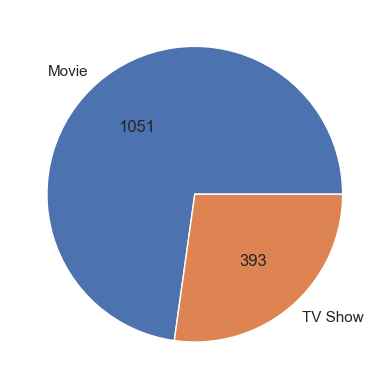

In [ ]:
data = cleaned_df["title"].groupby(level="type").count().sort_values(ascending=False)
_ = plt.pie(
    x=data,
    labels=data.index.get_level_values("type"),
    autopct=lambda x: int(x / 100 * data.sum()),
)

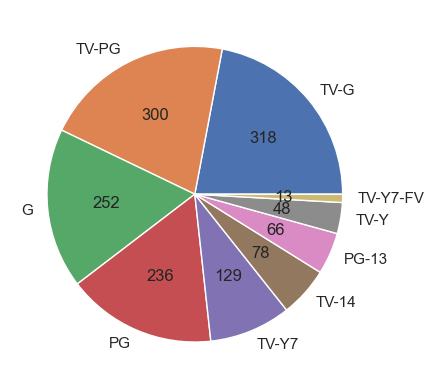

In [ ]:
data = cleaned_df["title"].groupby(level="rating").count().sort_values(ascending=False)
_ = plt.pie(
    x=data,
    labels=data.index.get_level_values("rating"),
    autopct=lambda x: int(x / 100 * data.sum()),
)

c:\Users\David\venv\2022f_data5006\lib\site-packages\seaborn\distributions.py:499: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
c:\Users\David\venv\2022f_data5006\lib\site-packages\seaborn\distributions.py:500: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(widths, name="widths"),


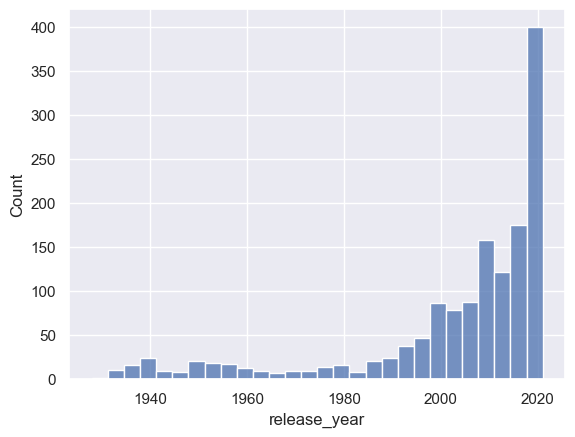

In [ ]:
_ = sns.histplot(data=cleaned_df, x="release_year")

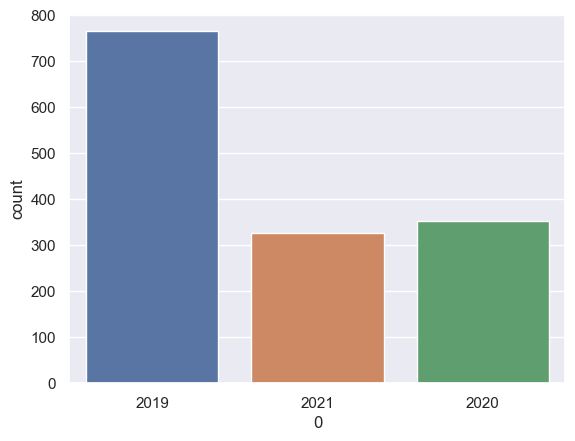

In [ ]:
data = cleaned_df.index.get_level_values("date_added").strftime("%Y-%m")
_ = sns.countplot(x=data.str.extract("([0-9]+)").loc[:, 0])

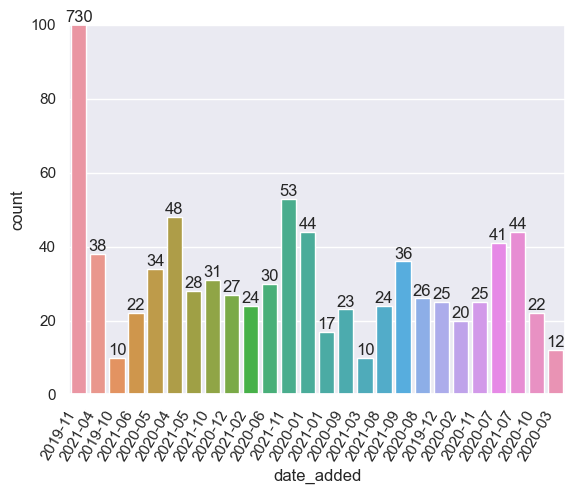

In [ ]:
p: plt.Axes = sns.countplot(x=data)

bar_container: BarContainer = p.containers[0]
labels: list[Text] = p.bar_label(bar_container)

p.set_ybound(lower=0, upper=100)
# add a valuej label for the clipped bar
p.text(
    x=bar_container.patches[0].get_center()[0],
    y=100,
    s=int(bar_container.datavalues[0]),
    fontsize=labels[0].get_fontsize(),
    ha="center",
    va="bottom",
)

_ = {rotate_label(label, rotation=60) for label in p.get_xticklabels()}